Задача.

Построить модель классификации стекла по химическому составу.

план:
1. EDA: Анализируем данные, проверяем на пропуски, визуализируем связи.
2. Предобработка: Масштабируем данные, разделяем их на обучающую и тестовую выборки.
3. Модели: Обучаем три классификационные модели — Logistic Regression, Random Forest и SVM.
4. Подбор гиперпараметров: Для каждой модели используем GridSearchCV для нахождения оптимальных гиперпараметров.
5. Оценка: Оценим модели по меткам точности, F1-скор и матрицам ошибок.
6. Сравнение: Сравниваем точности моделей.
7. Сохранение: Сохраняем лучшую модель для дальнейшего использования.

In [184]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

Создадим переменные для загрузки данных

In [185]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data'
columns = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']

Создадим датасет

In [186]:
df = pd.read_csv(url, names=columns, index_col=False)

In [187]:
df.head()

,Id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,2,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,3,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,4,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,5,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


Удалим колонку с индексами, так как она дублируется

In [188]:
df = df.drop(columns=['Id'])

Сохраним датасет в формате csv

In [189]:
df.to_csv('glass_identification.csv', index=False)

**1. EDA: Анализируем данные, проверяем на пропуски, визуализируем связи.**

In [190]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 214 entries, 0 to 213
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RI      214 non-null    float64
 1   Na      214 non-null    float64
 2   Mg      214 non-null    float64
 3   Al      214 non-null    float64
 4   Si      214 non-null    float64
 5   K       214 non-null    float64
 6   Ca      214 non-null    float64
 7   Ba      214 non-null    float64
 8   Fe      214 non-null    float64
 9   Type    214 non-null    int64  
dtypes: float64(9), int64(1)
memory usage: 16.8 KB


Проверим данные на пропуски

In [191]:
df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

Пропусков нет.

Рассмотрим статистику

In [192]:
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516522,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


Общий вывод:

В датасете 214 строк (наблюдений) и 10 признаков, включая целевую переменную Type (которая, вероятно, является категорией типа стекла).
Признаки варьируются от химического состава стекла до различных его характеристик.
Признаки:

RI (Индекс преломления):
Среднее значение: 1.518.
Диапазон: от 1.511 до 1.534.
Стандартное отклонение: 0.003 — это очень небольшая вариативность, что означает, что значения индекса преломления стекол в данном наборе данных относительно схожи.

Na (Натрий):
Среднее значение: 13.41.
Диапазон: от 10.73 до 17.38.
Стандартное отклонение: 0.82 — значение натрия варьируется значительно, с небольшим преобладанием концентраций около 13.
25-й и 75-й процентиль показывают, что половина наблюдений сосредоточена в интервале от 12.91 до 13.83.

Mg (Магний):
Среднее значение: 2.68.
Диапазон: от 0 до 4.49.
Стандартное отклонение: 1.44 — магний сильно варьируется в данных, в том числе есть значения, близкие к нулю, что может свидетельствовать о различных типах стекла (некоторые из них могут не содержать магния вообще).

Al (Алюминий):
Среднее значение: 1.44.
Диапазон: от 0.29 до 3.5.
Стандартное отклонение: 0.5 — алюминий имеет значительное распределение в данных, с наиболее частыми значениями около 1.44 и до 3.5.

Si (Кремний):
Среднее значение: 72.65.
Диапазон: от 69.81 до 75.41.
Стандартное отклонение: 0.77 — кремний в составе стекол варьируется, но в пределах узкого диапазона, что может указывать на его важность в составе большинства типов стекла.

K (Калий):
Среднее значение: 0.5.
Диапазон: от 0 до 6.21.
Стандартное отклонение: 0.65 — калий варьируется от нуля до высоких значений, но его концентрация невелика, что может свидетельствовать о его менее важной роли в составе.

Ca (Кальций):
Среднее значение: 8.96.
Диапазон: от 5.43 до 16.19.
Стандартное отклонение: 1.42 — кальций также сильно варьируется, и большинство данных сосредоточено в диапазоне от 8.24 до 9.17.

Ba (Барий):
Среднее значение: 0.18.
Диапазон: от 0 до 3.15.
Стандартное отклонение: 0.5 — барий имеет небольшие значения, и большинство данных находятся в районе нуля (что может говорить о его минимальной роли в составе).

Fe (Железо):
Среднее значение: 0.06.
Диапазон: от 0 до 0.51.
Стандартное отклонение: 0.1 — железо встречается в небольших количествах, с подавляющим большинством данных, равным нулю (возможно, не используется в некоторых типах стекол).

Type (Тип стекла):
Среднее значение: 2.78.
Диапазон: от 1 до 7.
Это категориальный признак, который указывает на тип стекла. Это важно для задачи классификации.

Построим гистограмму для каждого признака

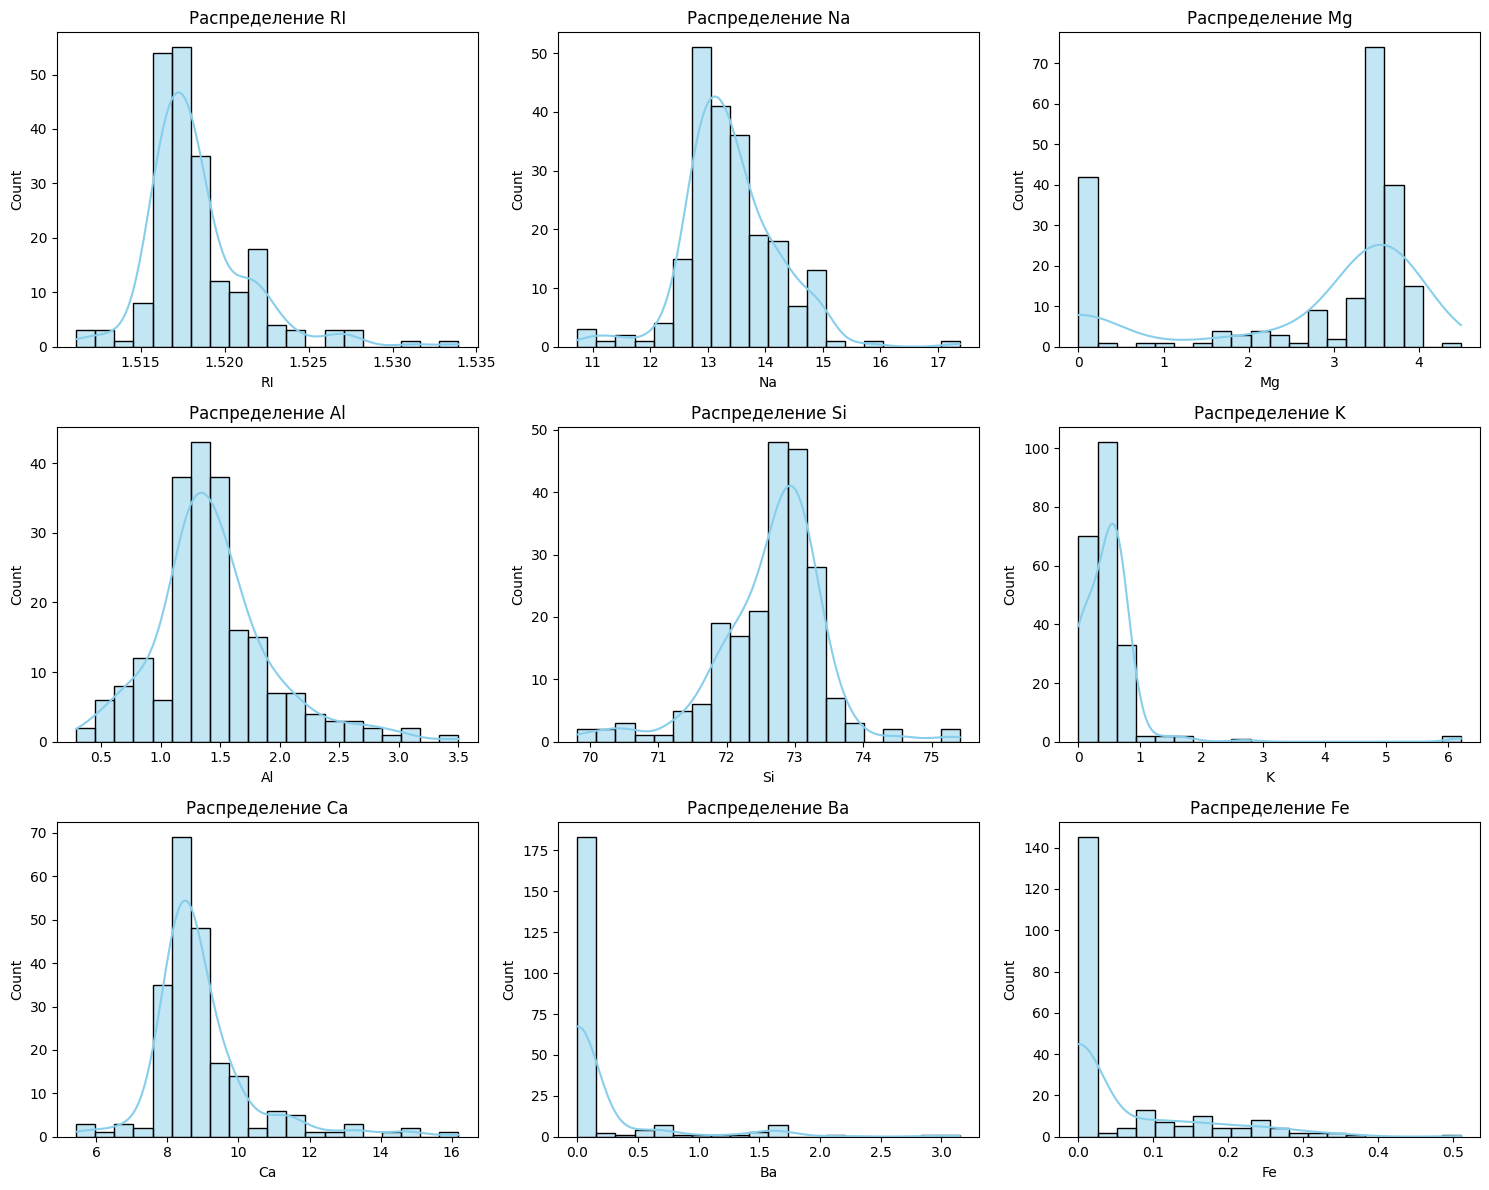

In [193]:
# Список признаков
features = ['RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe']

# Создаем графики для каждого признака
plt.figure(figsize=(15, 12))  # Размер графика

for i, feature in enumerate(features, 1):
    plt.subplot(3, 3, i)  # 3 строки и 3 столбца
    sns.histplot(df[feature], kde=True, bins=20, color='skyblue')  # Гистограмма с KDE
    plt.title(f'Распределение {feature}')
    plt.tight_layout()  # Автоматически подгоняет отступы между графиками

plt.show()

Выводы:
Признаки в данных имеют разные масштабы и диапазоны, что указывает на необходимость их нормализации или масштабирования (например, с помощью StandardScaler), особенно для моделей, чувствительных к масштабу (например, SVM или логистическая регрессия).
В некоторых признаках есть довольно большие различия (например, Na, Mg), что может указывать на разнообразие типов стекол с различными химическими составами.
Признаки, такие как Si (кремний) и Ca (кальций), имеют достаточно узкие диапазоны, что может свидетельствовать о том, что эти элементы имеют более стабильное содержание в стекле разных типов.
Признак Fe (железо) имеет минимальную вариативность, что может указывать на то, что этот элемент либо не используется в некоторых типах стекол, либо используется в очень малых количествах.

Признаки имеют нормальное распределение, кроме Ba, Fe, K и Mg. Значит мы будем подбирать модели, устойчивые к отклонениям в распределении.

**2. Предобработка данных**

In [194]:
from sklearn.preprocessing import StandardScaler

Разделим данные на признаки и целевую переменную

In [195]:
X = df.drop(columns=['Type'])
y = df['Type']

Масштабируем данные

In [196]:
scaler = StandardScaler()

Разделение на тренировочную и тестовую выборки

In [197]:
from sklearn.model_selection import train_test_split

In [198]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [199]:
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**3. Выбор и обучение моделей**

Для классификации мы будем использовать три модели: Logistic Regression, Random Forest и Support Vector Machine (SVM).

- Logistic Regression

In [200]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

In [201]:
# Инициализация модели
logreg = LogisticRegression(max_iter=10000)

Подбор гиперпараметров с помощью GridSearchCV

In [202]:
param_grid_logreg = {'C': [0.1, 1, 10],
                     'solver': ['liblinear', 'saga']}

In [203]:
grid_logreg = GridSearchCV(logreg, param_grid_logreg, cv=5, n_jobs=-1)

In [204]:
grid_logreg.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']})

Посмотрим Лучшие гиперпараметры

In [205]:
print(f"Лучшие гиперпараметры для логистической регрессии: {grid_logreg.best_params_}")

Лучшие гиперпараметры для логистической регрессии: {'C': 0.1, 'solver': 'saga'}


- Random Forest

In [206]:
from sklearn.ensemble import RandomForestClassifier

In [207]:
# Инициализация модели
rf = RandomForestClassifier(random_state=42)

In [208]:
# Подбор гиперпараметров с помощью GridSearchCV
param_grid_rf = {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10]
}

In [209]:
grid_rf = GridSearchCV(rf, param_grid_rf, cv=5, n_jobs=-1)

In [210]:
grid_rf.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 200]})

In [211]:
# Лучшие гиперпараметры
print(f"Лучшие гиперпараметры для Random Forest: {grid_rf.best_params_}")

Лучшие гиперпараметры для Random Forest: {'max_depth': 10, 'min_samples_split': 5, 'n_estimators': 200}


- Support Vector Machine (SVM)

In [212]:
from sklearn.svm import SVC

In [213]:
# Инициализация модели
svm = SVC(random_state=42)

In [214]:
# Подбор гиперпараметров с помощью GridSearchCV
param_grid_svm = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

In [215]:
grid_svm = GridSearchCV(svm, param_grid_svm, cv=5, n_jobs=-1)

In [216]:
grid_svm.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['linear', 'rbf']})

In [217]:
# Лучшие гиперпараметры
print(f"Лучшие гиперпараметры для SVM: {grid_svm.best_params_}")

Лучшие гиперпараметры для SVM: {'C': 1, 'gamma': 'scale', 'kernel': 'rbf'}


**4. Оценка моделей**

In [218]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

In [219]:
# Оценка для Logistic Regression
y_pred_logreg = grid_logreg.predict(X_test_scaled)
print("Оценка для Logistic Regression:")
print(classification_report(y_test, y_pred_logreg))
print(confusion_matrix(y_test, y_pred_logreg))

Оценка для Logistic Regression:
              precision    recall  f1-score   support

           1       0.57      0.73      0.64        11
           2       0.50      0.64      0.56        14
           3       0.00      0.00      0.00         3
           5       1.00      0.25      0.40         4
           6       1.00      0.33      0.50         3
           7       0.89      1.00      0.94         8

    accuracy                           0.63        43
   macro avg       0.66      0.49      0.51        43
weighted avg       0.64      0.63      0.59        43

[[8 3 0 0 0 0]
 [5 9 0 0 0 0]
 [1 2 0 0 0 0]
 [0 3 0 1 0 0]
 [0 1 0 0 1 1]
 [0 0 0 0 0 8]]


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Модель Logistic Regression показала высокие результаты, с точностью 63%. Она хорошо классифицирует классы 1, 2, 6 и 7, но имеет проблемы с классом 3, а также с низким recall для класса 5. 

Точность (accuracy): Модель достигла точности 63%, что является не плохим показателем, но еще далек от оптимальных значений.

Precision: 0.66. Это довольно хороший показатель, который указывает на то, что модель, в целом, делает меньше ошибок при классификации объектов.

Recall: 0.49. Это говорит о том, что модель находит около 50% объектов каждого класса.

F1-score: 0.51. Этот показатель также указывает на улучшение качества модели, но еще далек от оптимальных значений.

Матрица ошибок (confusion matrix) показывает:

Классы 1 и 2: Модель успешно классифицирует объекты этих классов, но также присутствуют ошибки. Например, некоторые объекты класса 1 ошибочно классифицированы как класс 2 и наоборот.
Класс 3: Модель не смогла правильно классифицировать объекты этого класса, что приводит к полной ошибке при классификации этого класса.
Класс 5: Несмотря на отличные результаты по precision, модель не находит все объекты этого класса (низкий recall), что указывает на его недостаточную репрезентативность в обучающем наборе данных.
Класс 7: Модель очень хорошо справляется с этим классом, что видно из того, что все объекты класса 7 были правильно классифицированы.

In [220]:
# Оценка для Random Forest
y_pred_rf = grid_rf.predict(X_test_scaled)
print("\nОценка для Random Forest:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


Оценка для Random Forest:
              precision    recall  f1-score   support

           1       0.73      1.00      0.85        11
           2       0.83      0.71      0.77        14
           3       1.00      0.67      0.80         3
           5       1.00      0.50      0.67         4
           6       1.00      1.00      1.00         3
           7       0.89      1.00      0.94         8

    accuracy                           0.84        43
   macro avg       0.91      0.81      0.84        43
weighted avg       0.86      0.84      0.83        43

[[11  0  0  0  0  0]
 [ 3 10  0  0  0  1]
 [ 1  0  2  0  0  0]
 [ 0  2  0  2  0  0]
 [ 0  0  0  0  3  0]
 [ 0  0  0  0  0  8]]


Модель Random Forest показала отличные результаты с точностью 84%, что является хорошим показателем для многоклассовой задачи. Модель успешно классифицирует классы 1, 6 и 7, и имеет хорошие результаты по классу 2. Однако есть некоторое снижение качества для классов 3 и 5, что требует дальнейшей настройки и балансировки данных. В целом, Random Forest является очень эффективной моделью для данной задачи.

Точность (accuracy): Модель достигла точности 84%, что является отличным результатом для многоклассовой классификации. Это свидетельствует о том, что Random Forest эффективно решает задачу классификации и значительно опережает как Logistic Regression (63%)

Precision: 0.91. Это очень высокий показатель, который указывает на то, что модель делает очень мало ложных срабатываний при классификации объектов каждого класса.

Recall: 0.81. Это также высокий показатель, который говорит о том, что модель находит большинство объектов каждого класса.

F1-score: 0.84. Это подтверждает, что модель обладает хорошим балансом между точностью и полнотой, что делает её очень эффективной в решении задачи.


Матрица ошибок (confusion matrix) показывает, что:

Классы 1, 6, и 7: Модель очень хорошо классифицирует объекты этих классов, почти без ошибок.
Класс 2: Есть небольшие ошибки (например, объект класса 2 может быть ошибочно классифицирован как класс 1).
Класс 3: Все объекты этого класса классифицируются верно, но не все объекты этого класса были найдены (недостаточная полнота).
Класс 5: Все объекты этого класса правильно классифицируются, но модель не находит все объекты этого класса, что приводит к среднему recall.

In [221]:
# Оценка для SVM
y_pred_svm = grid_svm.predict(X_test_scaled)
print("\nОценка для SVM:")
print(classification_report(y_test, y_pred_svm))
print(confusion_matrix(y_test, y_pred_svm))


Оценка для SVM:
              precision    recall  f1-score   support

           1       0.69      1.00      0.81        11
           2       0.67      0.71      0.69        14
           3       0.00      0.00      0.00         3
           5       0.67      0.50      0.57         4
           6       0.50      0.33      0.40         3
           7       1.00      0.88      0.93         8

    accuracy                           0.72        43
   macro avg       0.59      0.57      0.57        43
weighted avg       0.68      0.72      0.69        43

[[11  0  0  0  0  0]
 [ 4 10  0  0  0  0]
 [ 1  2  0  0  0  0]
 [ 0  2  0  2  0  0]
 [ 0  1  0  1  1  0]
 [ 0  0  0  0  1  7]]


c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mmd28\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

Модель SVM показала хорошую общую точность 72%, однако есть проблемы с классификацией некоторых классов, особенно с классом 3. Модель имеет высокую производительность для классов 1 и 7, но требует дополнительной настройки для других классов, чтобы улучшить результаты.

Точность (accuracy): Модель достигла точности 72%, что является хорошим результатом для многоклассовой классификации. Это указывает на то, что модель смогла эффективно классифицировать большинство объектов.

Precision: 0.59. Средняя точность всех классов, что указывает на сбалансированную производительность модели, но с возможными проблемами в некоторых классах.

Recall: 0.57. Средняя полнота всех классов. Модель находит около 57% объектов каждого класса в среднем.

F1-score: 0.57. Это означает, что модель имеет сбалансированную производительность по точности и полноте.

Матрица ошибок:
Классы 1 и 7: Эти классы классифицируются очень точно, с высокой полнотой и точностью.
Класс 2: Модель ошибается на некоторых объектах, но в целом хорошо классифицирует этот класс.
Классы 3, 5, и 6: Модель ошибается в классификации объектов этих классов, особенно для класса 3, который вообще не классифицируется.

**5. Сравнение моделей**

Для сравнения моделей можно использовать их точность или F1-скор. Выведем их для наглядности:

In [222]:
# Сравнение точности моделей
accuracy_logreg = accuracy_score(y_test, y_pred_logreg)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
accuracy_svm = accuracy_score(y_test, y_pred_svm)

print(f"\nТочность Logistic Regression: {accuracy_logreg}")
print(f"Точность Random Forest: {accuracy_rf}")
print(f"Точность SVM: {accuracy_svm}")


Точность Logistic Regression: 0.627906976744186
Точность Random Forest: 0.8372093023255814
Точность SVM: 0.7209302325581395


In [223]:
y[2]

np.int64(1)

In [224]:
y_pred_rf[2]

np.int64(1)

6. Сохранение лучшей модели (Random Forest)

import joblib

# Сохраняем лучшую модель
best_model = grid_rf if accuracy_rf > max(accuracy_logreg, accuracy_svm) else (grid_logreg if accuracy_logreg > accuracy_svm else grid_svm)
joblib.dump(best_model.best_estimator_, 'best_model.pkl')

print("Модель сохранена как 'best_model.pkl'")